## TODO
- relative entropy per gene per tissue relative to isoform fractions in other tissues (KL divergence)?
- Should be doing the isoform ratios at the sample level before aggregating
- map GC grp to our isoform names

In [1]:
from pathlib import Path

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../../data/internal/GTEx-protein-gencode/protein.GC30-basic.txt',
                 sep='\t')
metadata = pd.read_csv('../../data/internal/GTEx-protein-gencode/SRA-filtered.txt',
                       sep='\t')
if metadata['UID'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
metadata = metadata.set_index('UID')
if df.columns.duplicated().any():
    raise UserWarning('Unexpected duplicates')
if df['UID'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
df = df.set_index('UID')
df = (df + 1.).apply(np.log2)

In [3]:
hpa = pd.read_csv('../../data/internal/a_kallisto_hpa_tpms_prot_seq_grouped_w_lambert.tsv',
                 sep='\t')
hpa = hpa.loc[hpa['is_lambert'] == 1, :]
hpa = hpa.set_index('target_id')
hpa_genes = hpa['gene'].copy()
hpa = hpa.iloc[:, 4:]
#hpa = (hpa + 1.).apply(np.log2)  # DEBUG: trying taking mean before log transform to recreate Sachi's code
hpa_metadata = pd.read_csv('../../data/internal/b_sample_manifest_E-MTAB-2836.sdrf.txt',
                          sep='\t')
hpa_metadata['ID'] = (hpa_metadata['Comment[ENA_RUN]'] + '|' + hpa_metadata['Comment[ENA_SAMPLE]'])
hpa_tissues = (hpa_metadata.loc[:, ['ID', 'Factor Value[organism part]']]
                           .drop_duplicates()
                           .set_index('ID')
                           ['Factor Value[organism part]']
                           .copy())
if not hpa.columns.isin(hpa_tissues.index).all():
    raise UserWarining('Something went wrong')
hpa_means = hpa.groupby(hpa.columns.map(hpa_tissues), axis=1).mean()
hpa_means = (hpa_means + 1.).apply(np.log2)  # DEBUG: trying taking mean before log transform to recreate Sachi's code

In [4]:
genes = pd.Series(index=df.index,
                  data=df.index.str.extract('GC grp\: ([A-Z0-9orf]{2,10})-.*', expand=False).values)

In [5]:
means = df.groupby(df.columns.map(metadata['body_site']), axis=1).mean()
medians = df.groupby(df.columns.map(metadata['body_site']), axis=1).median()
tip_score = (means.sub(means.median(axis=1), axis=0)
                    .div(means.quantile(q=0.75, axis=1) -
                         means.quantile(q=0.25, axis=1), axis=0))
f_i = means.div(means.sum(axis=1), axis=0)
q_i = 1. / f_i.shape[1]  # this is relative entropy
entropy_per_isoform = (f_i.mul((f_i / q_i).apply(np.log2))).sum(axis=1)
# gene-level tissue-speceficity metrics
gene_means = df.groupby(genes).sum().groupby(df.columns.map(metadata['body_site']), axis=1).mean()
gene_medians = df.groupby(genes).sum().groupby(df.columns.map(metadata['body_site']), axis=1).mean()
gene_tip = (gene_means.sub(gene_means.median(axis=1), axis=0)
                    .div(gene_means.quantile(q=0.75, axis=1) -
                         gene_means.quantile(q=0.25, axis=1), axis=0))
f_i = gene_means.div(gene_means.sum(axis=1), axis=0)
q_i = 1. / f_i.shape[1]  # this is relative entropy
gene_entropy_per_isoform = (f_i.mul((f_i / q_i).apply(np.log2))).sum(axis=1)
iso = genes.to_frame(name='gene').copy()
iso['mean_logTPM'] = means.mean(axis=1)
iso['median_logTPM'] = medians.median(axis=1)
iso['max_logTPM'] = means.max(axis=1)
iso['max_TiP_score'] = tip_score.max(axis=1)
iso['tissue_with_max_TiP_score'] = tip_score.idxmax(axis=1)
iso['entropy'] = entropy_per_isoform
iso['gene_max_TiP_score'] = iso['gene'].map(gene_tip.max(axis=1))
iso['gene_entropy'] = iso['gene'].map(gene_entropy_per_isoform)
iso.head()

,gene,mean_logTPM,median_logTPM,max_logTPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy
UID,,,,,,,,,
GC grp: KCNIP3-201,KCNIP3,1.577801,1.101364,5.008550,2.180588,Brain - Frontal Cortex (BA9),0.498635,1.817019,0.150422
GC grp: KCNIP3-202,KCNIP3,1.781531,1.637533,3.729617,1.089647,Testis,0.283124,1.817019,0.150422
GC grp: KCNIP3-205,KCNIP3,0.784612,0.618098,1.876189,1.131689,Cervix - Endocervix,0.428055,1.817019,0.150422
GC grp: TFDP2-209,TFDP2,0.030298,0.000000,0.214965,5.665579,Muscle - Skeletal,0.964005,2.735584,0.082454
GC grp: NFATC2-206,NFATC2,0.037247,0.000000,0.152472,2.261455,Adipose - Subcutaneous,0.784859,1.716182,0.201238


1615 total TF genes in dataset
1553 genes with TPM > 1
3193 isoforms with TPM > 1
812 genes with ≥ 2 isoforms with TPM > 1


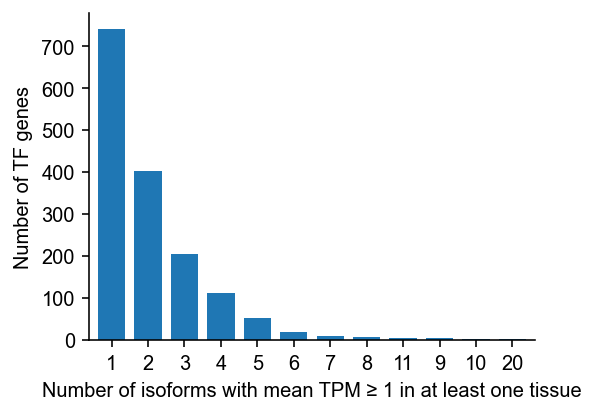

In [6]:
print(genes.nunique(), 'total TF genes in dataset')
print(genes[means.max(axis=1) > 1.].nunique(), 'genes with TPM > 1')
print(genes[means.max(axis=1) > 1.].shape[0], 'isoforms with TPM > 1')
print((genes[means.max(axis=1) > 1.].value_counts() >= 2).sum(), 'genes with ≥ 2 isoforms with TPM > 1')
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 3)
genes[means.max(axis=1) > 1.].value_counts().value_counts().plot.bar(rot=0,
                                                                     width=0.75,
                                                                     ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Number of TF genes')
ax.set_xlabel('Number of isoforms with mean TPM ≥ 1 in at least one tissue')
plt.savefig('../../figures/number_of_isoforms_gt_1TPM_per_tf_gene_GTEx.pdf',
            bbox_inches='tight')

In [7]:
means['Adipose - Subcutaneous'].sort_values()

UID
GC grp: MYT1L-226                                       0.000000
GC grp: GSX1-201                                        0.000000
GC grp: NFIB-202                                        0.000000
GC grp: MAZ-210                                         0.000000
GC grp: NR1H4-206                                       0.000000
                                                          ...   
GC grp: YBX1-201                                        7.917804
GC grp: EPAS1-201                                       8.034075
GC grp: JUN-201                                         8.057097
GC grp: NME2-205|NME2-207|NME2-202|NME2-206|NME2-204    8.805925
GC grp: ATF4-203|ATF4-202|ATF4-201                      9.098535
Name: Adipose - Subcutaneous, Length: 4130, dtype: float64

In [109]:
def number_dominant_isoforms_across_all_tissues(rows):
    n_isoforms = rows.shape[0]
    if n_isoforms == 0:
        return 0
    if n_isoforms == 1:
        if (rows >= 1.).any().any():
            return 1
        else:
            return 0
    dom_per_tissue = [dominant_isoform_in_tissue(rows[c]) for c in rows.columns]
    return len({iso_id for iso_id in dom_per_tissue if iso_id is not None})


def dominant_isoform_in_tissue(column):
    """Dominant isoform: TPM > 1 and 2-fold more expressed than second most expressed"""
    isoforms_ordered = column.sort_values(ascending=False)
    if isoforms_ordered.iloc[1] == 0:
        fold_change_1st_over_2nd = np.inf
    else:
        fold_change_1st_over_2nd = (2**isoforms_ordered.iloc[0] - 1) / (2**isoforms_ordered.iloc[1] - 1)
    if (isoforms_ordered.iloc[0] >= 1.) and fold_change_1st_over_2nd >= 2:
        return isoforms_ordered.index[0]
    else:
        return None
    

n_dom_per_iso = means.groupby(genes).apply(number_dominant_isoforms_across_all_tissues)
n_dom = n_dom_per_iso.value_counts().sort_index()
print(n_dom)
n_dom = n_dom[n_dom.index > 0]
n_dom

0     109
1    1393
2     110
3       1
4       1
5       1
dtype: int64


1    1393
2     110
3       1
4       1
5       1
dtype: int64

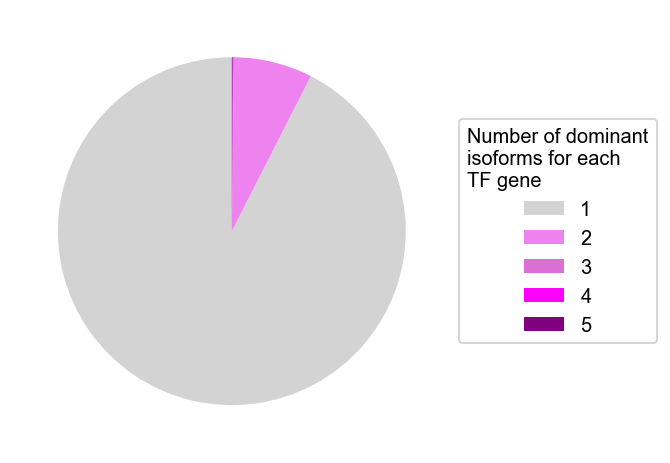

In [108]:
# make it look nicer
fig, ax = plt.subplots(1, 1)
n_dom.plot.pie(startangle=90,
               label='',
               labels=None,
               colors=['lightgrey', 'violet', 'orchid', 'magenta', 'purple'])
ax.legend(n_dom.index,
          loc='center left',
          bbox_to_anchor=[1, 0.5],
          title='Number of dominant\nisoforms for each\nTF gene')

In [53]:
# DEBUG

def number_dominant_isoforms_across_all_tissues(rows):
    n_isoforms = rows.shape[0]
    if n_isoforms == 0:
        return 0
    if n_isoforms == 1:
        if (rows >= 1.).any().any():
            return 1
        else:
            return 0
    dom_per_tissue = [dominant_isoform_in_tissue(rows[c]) for c in rows.columns]
    return len({iso_id for iso_id in dom_per_tissue if iso_id is not None})


def dominant_isoform_in_tissue(column):
    """Dominant isoform: TPM > 1 and 2-fold more expressed than second most expressed"""
    isoforms_ordered = column.sort_values(ascending=False)
    if isoforms_ordered.iloc[1] <= 1:  # DEBUG
        fold_change_1st_over_2nd = np.inf
    else:
        fold_change_1st_over_2nd = (2**isoforms_ordered.iloc[0] - 1) / (2**isoforms_ordered.iloc[1] - 1)
    if (isoforms_ordered.iloc[0] > 1.) and fold_change_1st_over_2nd >= 2:
        return isoforms_ordered.index[0]
    else:
        return None


n_dom_per_iso = hpa_means.groupby(hpa_genes).apply(number_dominant_isoforms_across_all_tissues)
n_dom = n_dom_per_iso.value_counts().sort_index()
n_dom = n_dom[n_dom.index > 0]
n_dom

1    1261
2     243
3      31
4       5
dtype: int64

Text(0.5, 1.0, 'Number of dominant isoforms per tissue using HPA data')

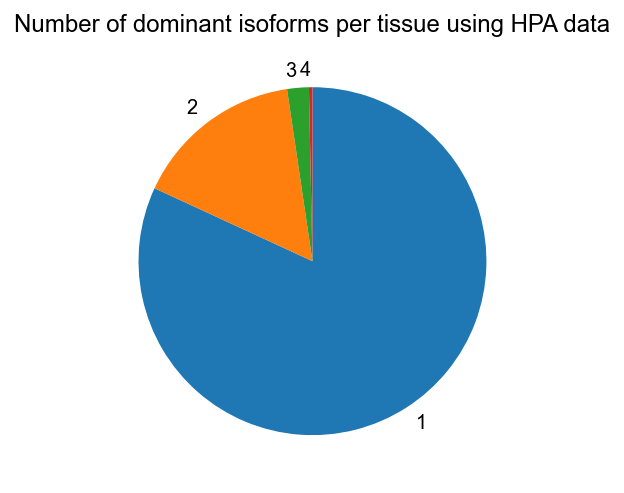

In [54]:
n_dom.plot.pie(startangle=90, label='', counterclock=False)
plt.title('Number of dominant isoforms per tissue using HPA data')

In [55]:
n_dom

1    1261
2     243
3      31
4       5
dtype: int64

In [15]:
n_dom_per_iso

gene
AC006213.1    1
AC008554.1    1
AC008770.2    0
AC008770.3    1
AC023509.3    1
             ..
ZSCAN9        2
ZUP1          1
ZXDA          1
ZXDB          1
ZXDC          1
Length: 1632, dtype: int64

In [52]:
n_dom_per_iso['POU5F1']

1

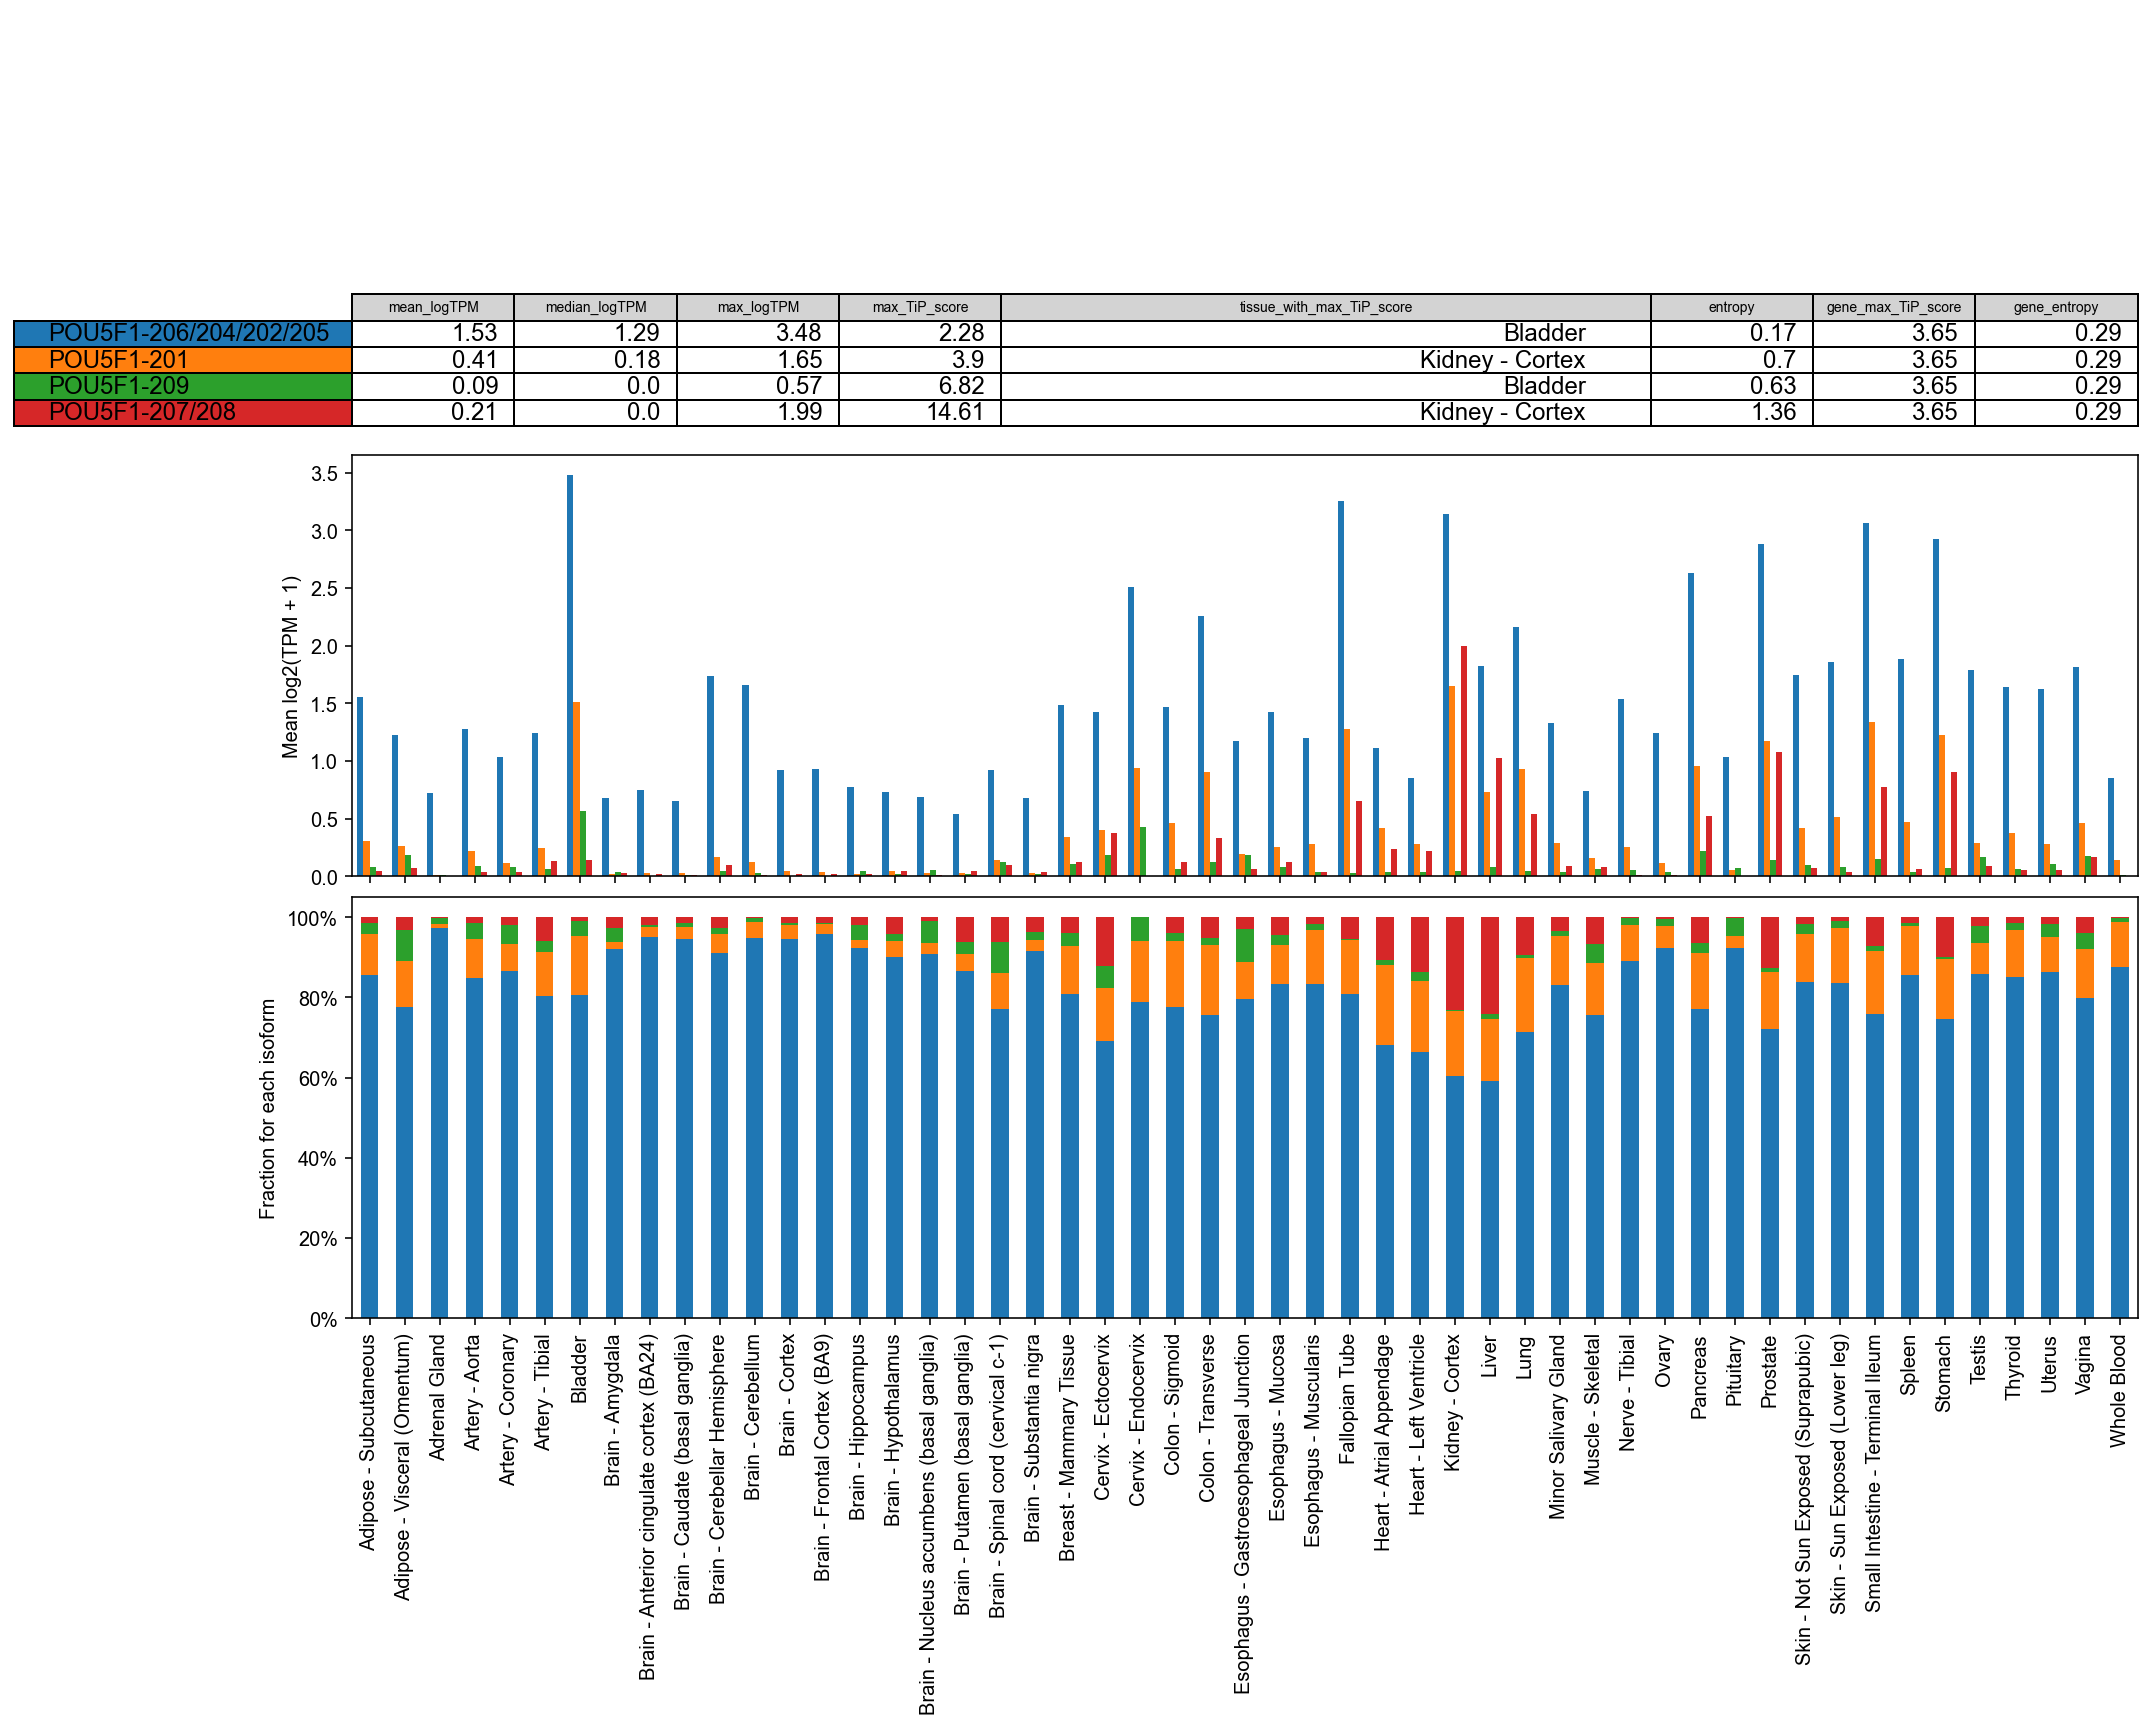

In [32]:
# this is out of order
table_and_graphs('POU5F1')

In [24]:
n_dom_per_iso['FOXM1']

3

In [30]:
#DEBUG
foxm1 = hpa_means.loc[hpa_means.index.isin(hpa_genes[(hpa_genes == 'FOXM1')].index), :]
foxm1.to_csv('/Users/lukelambourne/Desktop/foxM1_HPA_means.tsv', sep='\t')

In [31]:
foxm1

,adipose tissue,adrenal gland,bone marrow,cerebral cortex,colon,duodenum,endometrium,esophagus,fallopian tube,gall bladder,...,small intestine,smooth muscle tissue,spleen,stomach,testis,thyroid gland,tonsil,urinary bladder,vermiform appendix,zone of skin
target_id,,,,,,,,,,,,,,,,,,,,,
ENST00000342628.6|FOXM1,0.977070,0.526439,1.844032,0.942348,1.537909,1.069119,1.278463,1.252573,0.829195,1.284128,...,1.616731,1.690419,1.202796,1.448544,2.344810,1.338655,1.578074,1.526136,1.866606,2.312759
ENST00000359843.7|FOXM1,0.856947,0.478537,2.452668,0.259802,2.709515,2.780368,1.166677,2.459329,0.916651,0.890605,...,2.292735,2.804580,1.056941,1.815969,2.934390,0.428057,3.291951,0.892131,2.829147,2.234596
ENST00000361953.7|FOXM1,0.270917,0.000000,3.382075,1.193986,1.471810,1.123528,0.334989,0.815948,0.148476,0.438701,...,1.735446,0.366504,1.288508,0.516867,4.573589,0.190790,2.224101,0.000002,1.470454,0.337747
ENST00000627656.2|FOXM1,0.866413,0.475213,2.163685,0.538270,1.751093,1.150098,0.810491,1.381756,0.348792,0.674130,...,1.565055,1.482325,1.418477,1.370063,3.108608,0.671005,2.071005,1.475484,1.742982,2.208563


In [52]:
2 ** foxm1['lung'].values - 1

array([7.89658800e-01, 8.52148800e-01, 1.08827192e-09, 1.07965820e+00])

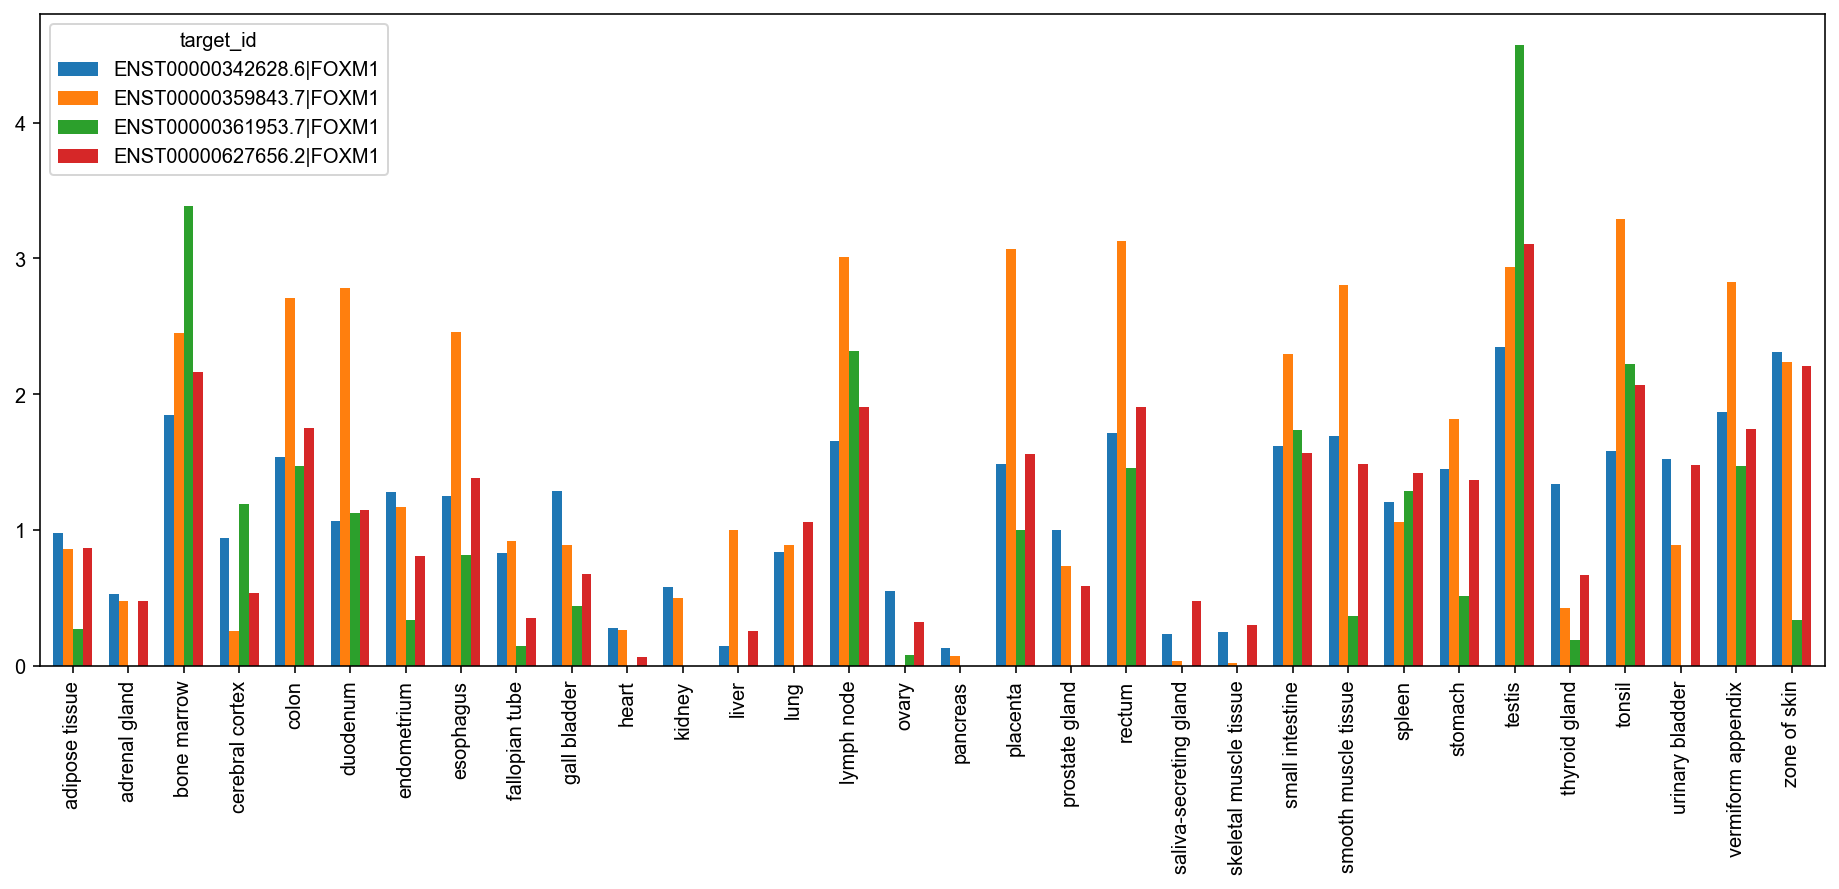

In [43]:
#DEBUG
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 6)
(hpa_means.loc[hpa_genes == 'FOXM1', :]
      .T
      .plot.bar(ax=ax,
                legend=True,
                width=0.7))

In [48]:
#DEBUG
def dominant_isoforms_across_all_tissues(rows):
    n_isoforms = rows.shape[0]
    if n_isoforms == 0:
        return 0
    if n_isoforms == 1:
        if (rows >= 1.).any().any():
            return 1
        else:
            return 0
    return {c: dominant_isoform_in_tissue(rows[c]) for c in rows.columns}

res = foxm1.groupby(hpa_genes).apply(dominant_isoforms_across_all_tissues)['FOXM1']
{k: v for k, v in res.items() if v is not None}

{'bone marrow': 'ENST00000361953.7|FOXM1',
 'colon': 'ENST00000359843.7|FOXM1',
 'duodenum': 'ENST00000359843.7|FOXM1',
 'esophagus': 'ENST00000359843.7|FOXM1',
 'placenta': 'ENST00000359843.7|FOXM1',
 'rectum': 'ENST00000359843.7|FOXM1',
 'smooth muscle tissue': 'ENST00000359843.7|FOXM1',
 'testis': 'ENST00000361953.7|FOXM1',
 'thyroid gland': 'ENST00000342628.6|FOXM1',
 'tonsil': 'ENST00000359843.7|FOXM1',
 'vermiform appendix': 'ENST00000359843.7|FOXM1'}

In [ ]:
table_and_graphs_hpa('FOXM1')

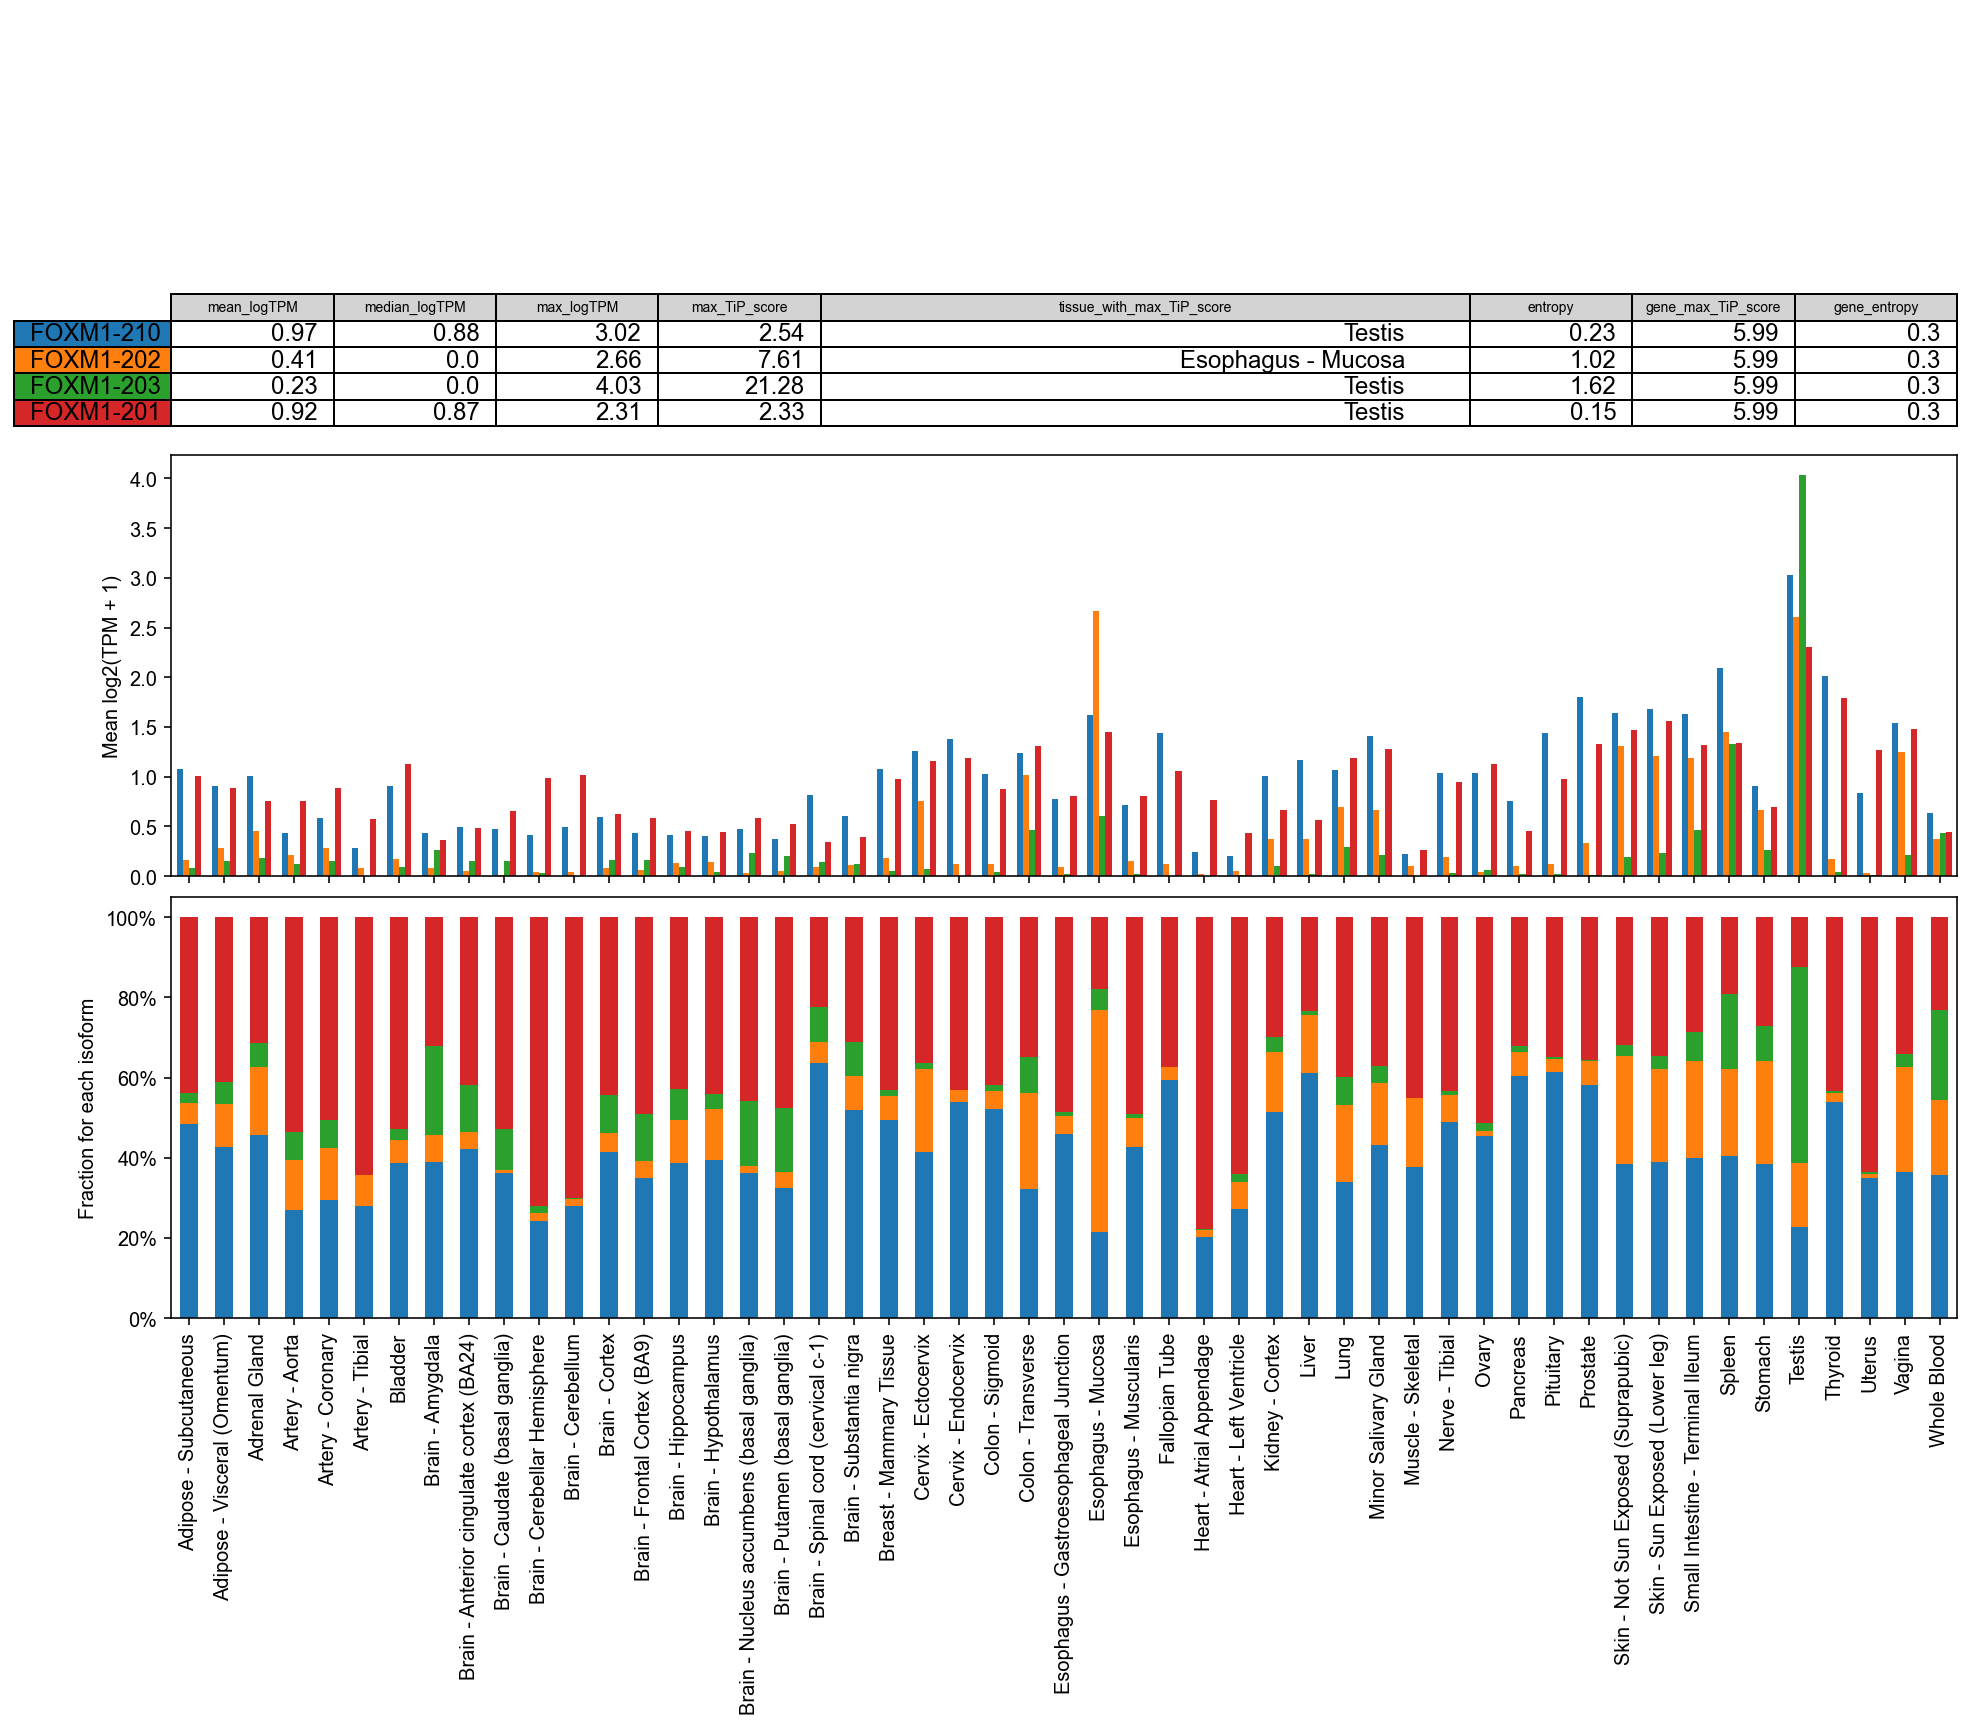

In [35]:
table_and_graphs('FOXM1')

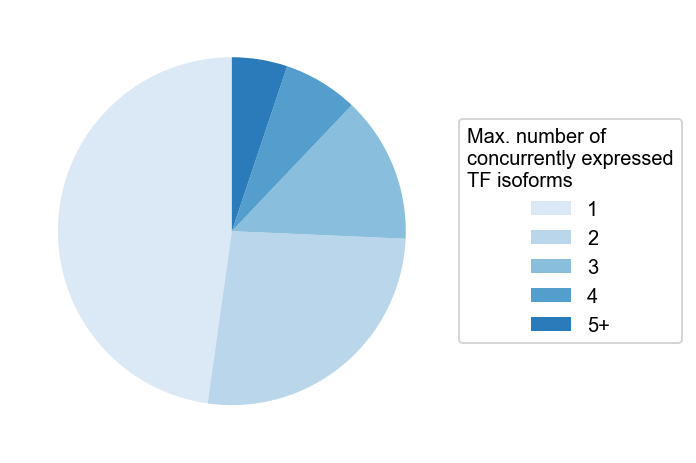

In [91]:
# colors
fig, ax = plt.subplots(1, 1)
coexp_iso = (means >= 1.).groupby(genes).sum().max(axis=1).value_counts().sort_index()
data_to_plot = {}
for i in range(1, 5):
    data_to_plot[str(i)] = coexp_iso[i]
data_to_plot['5+'] = coexp_iso.loc[coexp_iso.index >= 5].sum()
ax.pie(data_to_plot.values(),
       colors=sns.color_palette("Blues"),
       startangle=90)
ax.legend(data_to_plot.keys(),
          loc='center left',
          bbox_to_anchor=[1, 0.5],
          title='Max. number of\nconcurrently expressed\nTF isoforms')

In [18]:
(hpa_means > 1).any(axis=1).sum()

3803

Text(0.5, 1.0, 'Max number isoforms ≥ 1 TPM in a tissue per gene\nUsing HPA data')

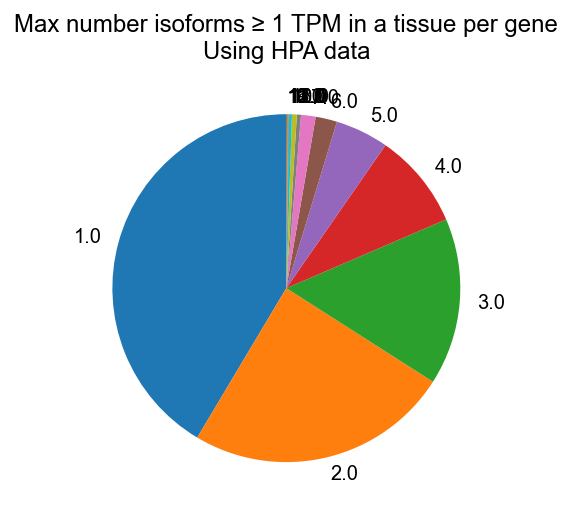

In [22]:
coexp_iso = (hpa_means > 1.).groupby(hpa_genes).sum().max(axis=1).value_counts().sort_index()
coexp_iso[coexp_iso.index > 0].plot.pie(startangle=90,
                                        label='')
plt.title('Max number isoforms ≥ 1 TPM in a tissue per gene\nUsing HPA data')

In [23]:
(coexp_iso[coexp_iso.index >= 2]).sum()

910

In [6]:
iso.sort_values('max_TiP_score', ascending=False).head()

,gene,mean_logTPM,median_logTPM,max_logTPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy
UID,,,,,,,,,
GC grp: TP53-221,TP53,1.948490e-08,0.0,9.828253e-07,inf,Brain - Spinal cord (cervical c-1),5.577190,0.703721,0.130711
GC grp: PAX5-207,PAX5,2.384453e-03,0.0,5.946602e-02,inf,Adipose - Subcutaneous,3.445139,67.896294,1.909189
GC grp: IKZF3-210,IKZF3,5.197684e-04,0.0,7.772308e-03,inf,Artery - Aorta,3.409749,8.532178,0.392771
GC grp: PAX5-206,PAX5,3.983880e-03,0.0,9.518032e-02,inf,Artery - Coronary,3.653918,67.896294,1.909189
GC grp: IKZF3-212,IKZF3,5.462950e-05,0.0,2.786104e-03,inf,Colon - Transverse,5.672425,8.532178,0.392771


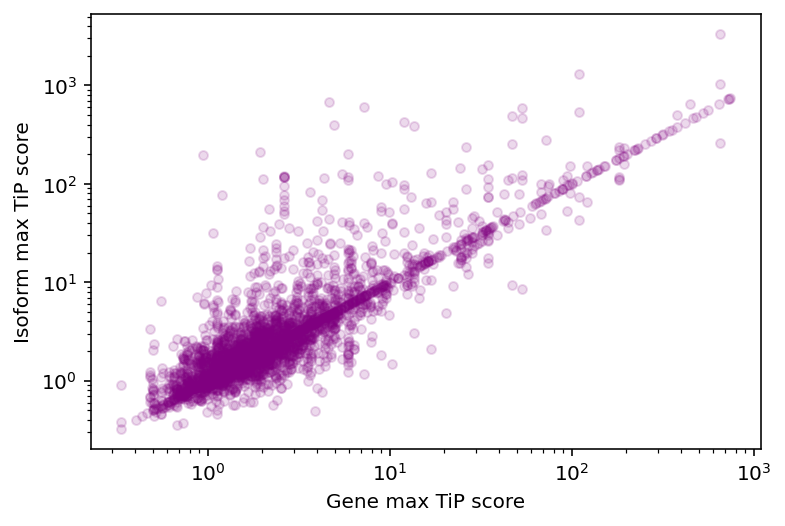

In [7]:
fig, ax = plt.subplots(1, 1)
(iso.loc[iso['max_logTPM'] > 1, :]
    .plot.scatter(x='gene_max_TiP_score',
                  y='max_TiP_score',
                  alpha=0.15,
                  color='purple',
                  ax=ax))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Isoform max TiP score')
ax.set_xlabel('Gene max TiP score')
plt.savefig('../../figures/isoform_vs_gene_TiP_score_scatter.pdf',
            bbox_inches='tight')

In [8]:
# theres a problem with infs in the TiP score
# a pseudo count wont help because it's in the IQR that's the problem 
# inspect inf values
(iso.loc[(iso['max_logTPM'] > 1) & 
         (iso['max_TiP_score'] == np.inf), :]
    .sort_values('max_TiP_score', ascending=False).head(60))

,gene,mean_logTPM,median_logTPM,max_logTPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy
UID,,,,,,,,,
GC grp: SPIB-206,SPIB,0.040626,0.0,1.092764,inf,Adrenal Gland,3.859802,16.789468,0.727254


In [9]:
iso['TiP_diff'] = iso['max_TiP_score'] - iso['gene_max_TiP_score']
(iso.loc[(iso['max_logTPM'] > 1), :]
    .sort_values('TiP_diff', ascending=False).head(30))

,gene,mean_logTPM,median_logTPM,max_logTPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy,TiP_diff
UID,,,,,,,,,,
GC grp: SPIB-206,SPIB,0.040626,0.000000,1.092764,inf,Adrenal Gland,3.859802,16.789468,0.727254,inf
GC grp: LHX3-201,LHX3,0.095715,0.000000,4.778114,3361.828281,Pituitary,5.457876,652.040875,4.582163,2709.787406
GC grp: PAX2-205,PAX2,0.100200,0.000000,2.827334,1296.929414,Kidney - Cortex,3.705177,109.524078,2.770859,1187.405336
GC grp: PGR-207,PGR,0.043924,0.000000,2.116144,679.326984,Testis,5.143680,4.627856,0.767239,674.699128
GC grp: ZSCAN29-204,ZSCAN29,0.042709,0.000000,2.070845,603.444588,Testis,5.174066,7.206938,0.106102,596.237650
GC grp: HNF4A-204,HNF4A,0.153605,0.000000,2.313671,594.661634,Liver,3.129956,53.520303,1.927585,541.141330
GC grp: HNF1A-201,HNF1A,0.173192,0.000000,1.616072,484.589767,Small Intestine - Terminal Ileum,2.850396,46.951494,2.000403,437.638273
GC grp: PAX2-203,PAX2,0.088933,0.000000,2.373144,539.273479,Kidney - Cortex,3.527768,109.524078,2.770859,429.749401
GC grp: HNF4A-202,HNF4A,0.094163,0.000000,1.135011,471.181525,Small Intestine - Terminal Ileum,2.868340,53.520303,1.927585,417.661222


In [10]:
table_and_graphs('GTF2IRD2')

NameError: name 'table_and_graphs' is not defined

In [ ]:
table_and_graphs('NKX2')

In [ ]:
table_and_graphs('TCF4')

In [ ]:
fig, ax = plt.subplots(1, 1)
(iso.loc[iso['max_logTPM'] > 1, :]
    .plot.scatter(x='gene_entropy',
                  y='entropy',
                  alpha=0.15,
                  color='purple',
                  ax=ax))
ax.set_ylabel('Isoform relative entropy')
ax.set_xlabel('Gene relative entropy')
plt.savefig('../../figures/isoform_vs_gene_entropy_scatter.pdf',
            bbox_inches='tight')

In [ ]:
iso['entropy_diff'] = iso['entropy'] - iso['gene_entropy']
(iso.loc[(iso['max_logTPM'] > 1), :]
    .sort_values('entropy_diff', ascending=False).head())

In [ ]:
# entropy per gene per tissue
entropy_per_tissue = pd.DataFrame(data=[means[c].groupby(genes).apply(stats.entropy, base=2) for c in means.columns]).T

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
sns.boxplot(data=entropy_per_tissue,
            ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Entropy per TF gene')

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
sns.boxplot(data=entropy_per_tissue.loc[genes.value_counts() == 3, :],
            ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Entropy per TF gene')

In [ ]:
genes.value_counts().value_counts().sort_index()

In [ ]:
entropy_per_tissue.idxmax().value_counts()

In [ ]:
# looks like the entropy per tissue is mainly measuring the number of isoforms
fig, ax = plt.subplots(1, 1)
x = genes.value_counts()[entropy_per_tissue.index].values
y = entropy_per_tissue.mean(axis=1).values
ax.scatter(x, y, alpha=0.2)
ax.set_xlabel('Number of isoforms per TF gene')
ax.set_ylabel('Mean per TF gene entropy per tissue')
(stats.spearmanr(x, y), stats.pearsonr(x, y))

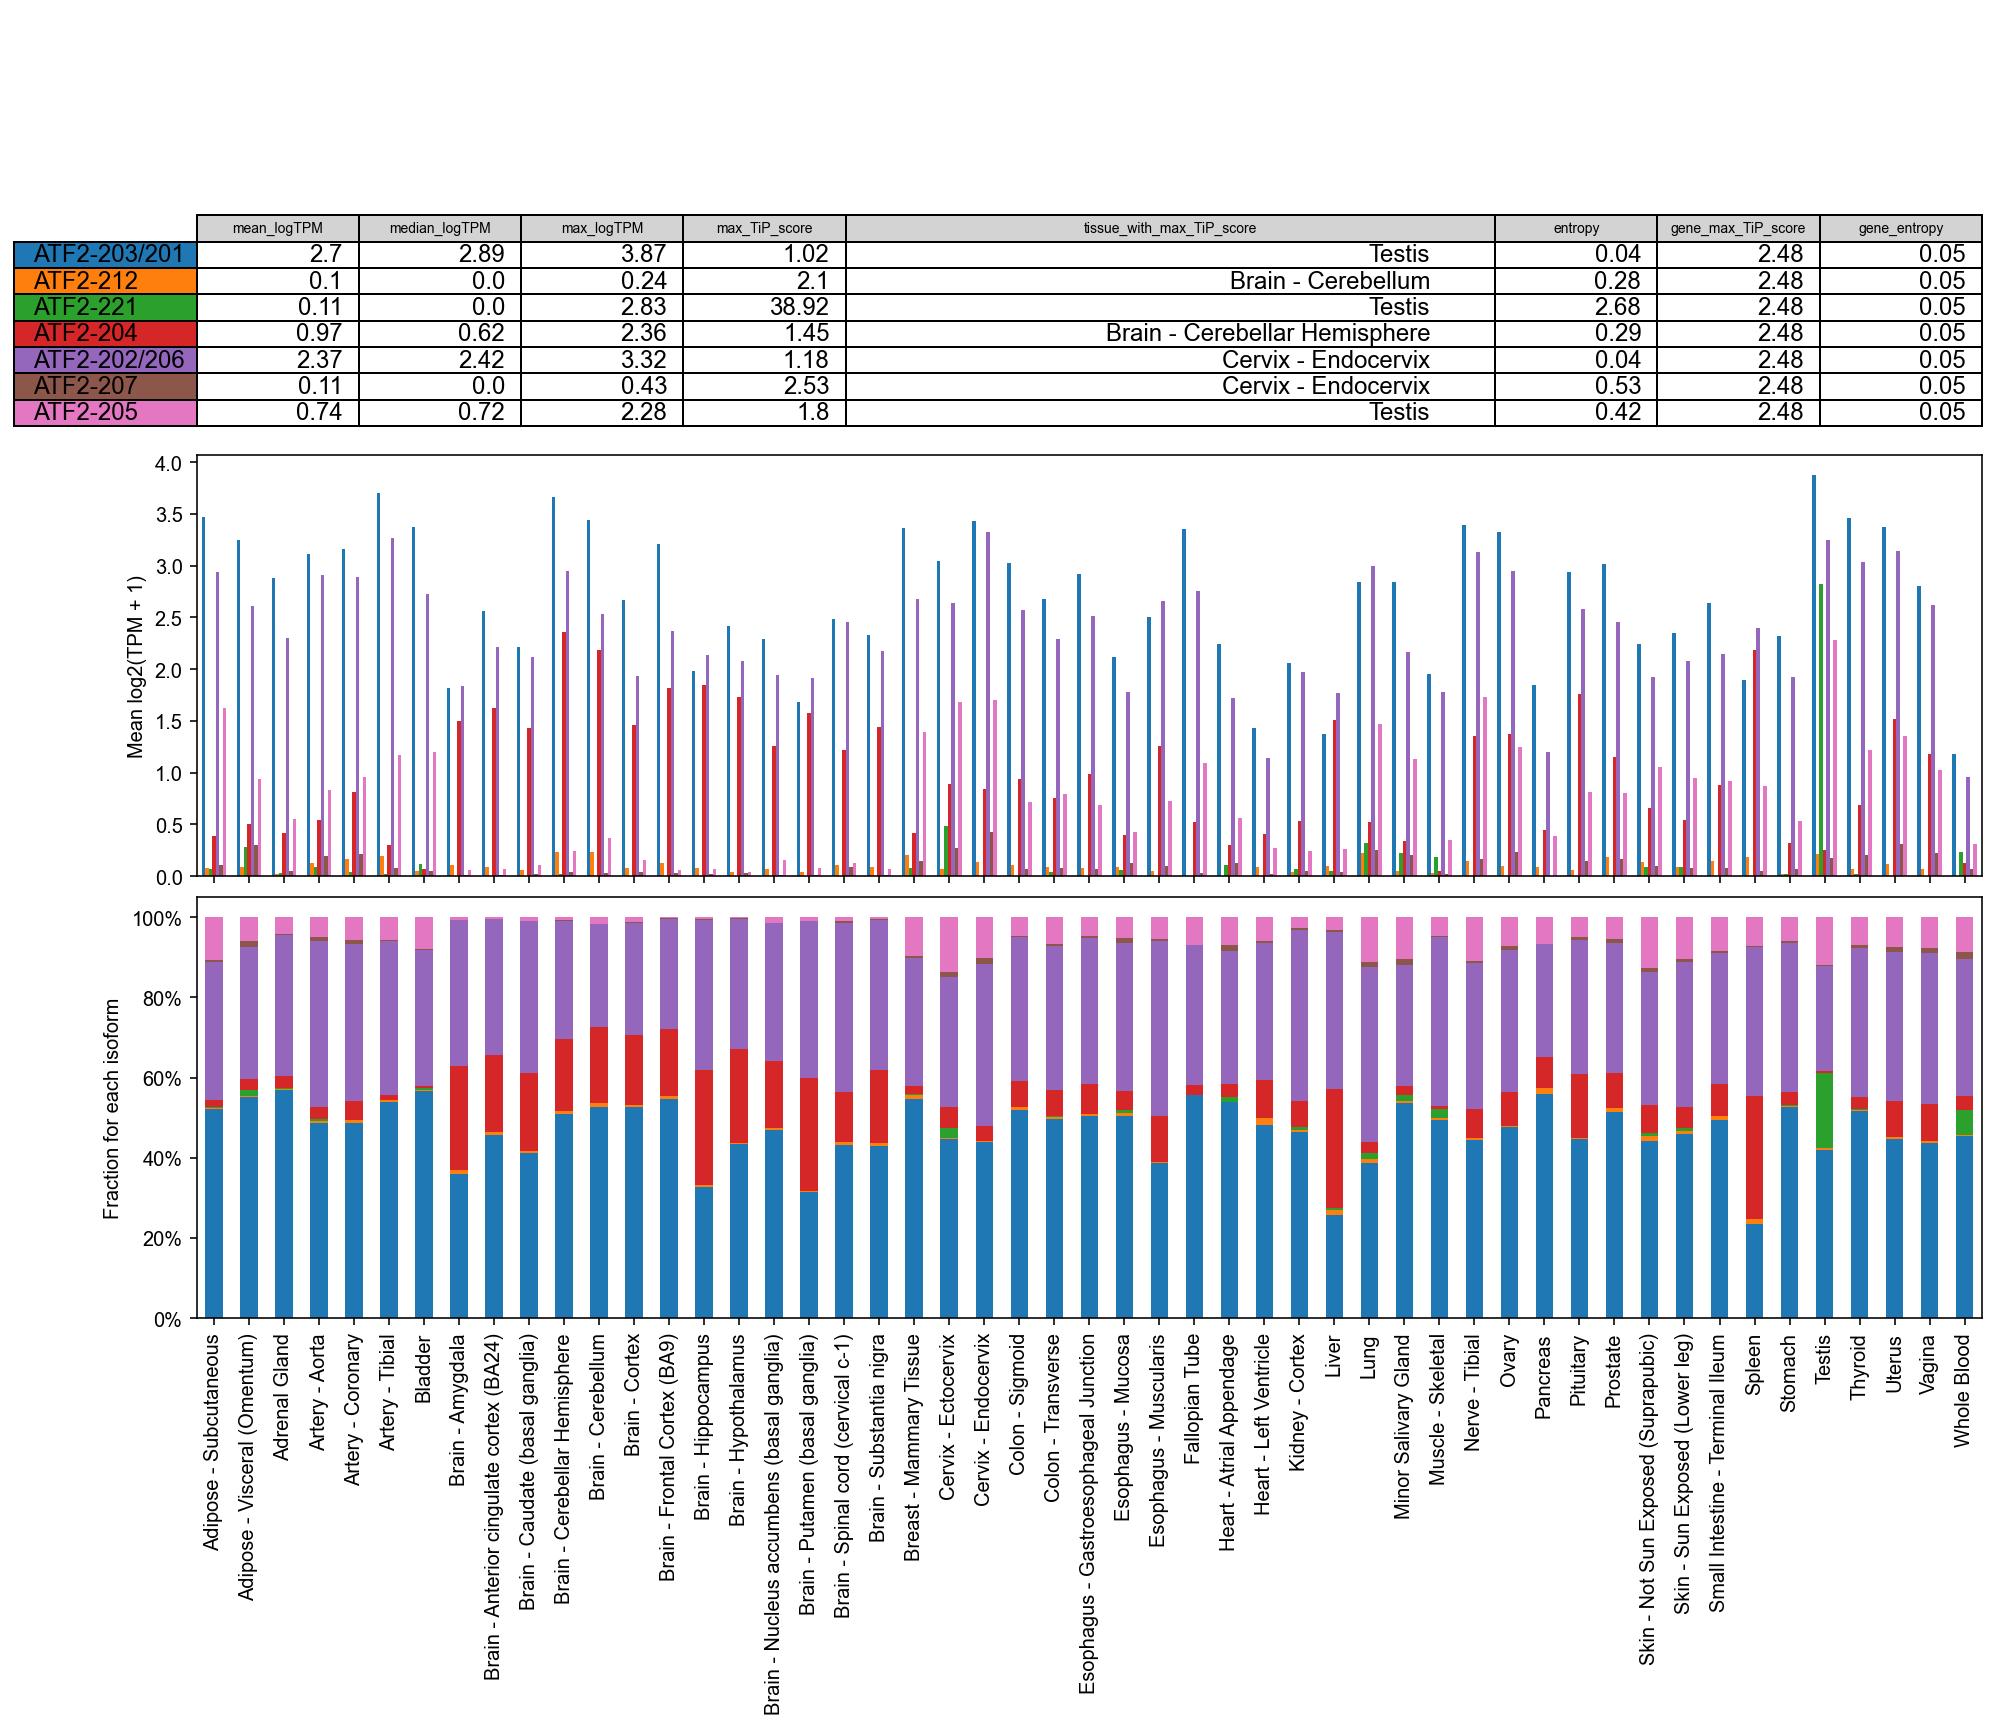

In [30]:
def table_and_graphs(gene_name):
    fig, axes = plt.subplots(3, 1, sharex=True)
    fig.set_size_inches(16, 12)
    ### table ###
    ncol = iso.shape[1] - 1
    data = iso.loc[iso['gene'] == gene_name, 
                   filter(lambda x: x != 'gene', iso.columns)].copy()
    data.index = data.index.str.replace('GC grp: ', '').str.replace('|' + gene_name+ '-', '/', regex=False)
    tab = pd.plotting.table(ax=axes[0],
                            data=data.round(2),
                            loc='lower center',
                            rowColours=['C' + str(i) for i in range((iso['gene'] == gene_name).sum())],
                            colColours=['lightgrey'] * ncol,
                            fontsize=32,
                            colWidths=[4 / (ncol + 3) if i == 4 else 1 / (ncol + 3) for i in range(ncol)])
    tab.auto_set_font_size(False)
    tab.set_fontsize(12)
    axes[0].axis('off')
    for key, cell in tab.get_celld().items():
        if key[0] == 0:
            cell.set_fontsize(7)
    ### bar chart ###
    (means.loc[genes == gene_name, :]
          .T
          .plot.bar(ax=axes[1],
                    legend=False,
                    width=0.7))
    ### percentages ###
    raw_means = 2 ** means.loc[genes == gene_name] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[2], 
                          stacked=True,
                          legend=False))
    axes[1].set_ylabel('Mean log2(TPM + 1)')
    #axes[0].set_title(gene_name)
    axes[2].set_ylabel('Fraction for each isoform')
    axes[2].set_yticklabels(['{:.0%}'.format(t) for t in axes[2].get_yticks()])
    plt.subplots_adjust(hspace=0.05)
    fig_dir = Path('../../figures/tissue_expression_per_gene')
    fig_dir.mkdir(exist_ok=True)
    plt.savefig(fig_dir / (gene_name + '_tissue_expression.pdf'),
                bbox_inches='tight')

table_and_graphs('ATF2')

In [ ]:
# largest number of isoforms
table_and_graphs('CREM')

In [ ]:
table_and_graphs('FOXP2')

In [ ]:
table_and_graphs('FOXM1')

In [ ]:
# interesting because all isoforms in one tissue
table_and_graphs('LHX3')

In [ ]:
table_and_graphs('ELF5')  # Zero counts

In [ ]:
table_and_graphs('SPIB')  # Zero counts

In [ ]:
table_and_graphs('TP53')

In [ ]:
table_and_graphs('ZSCAN29')

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 9)
iso.loc[(iso['max_logTPM'] > 1) & (iso['max_TiP_score'] > 5), 'tissue_with_max_TiP_score'].value_counts().plot.barh(ax=ax)
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel('Number of tissue specific isoforms')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0)
plt.savefig('../../figures/number_tissue_specific_isoforms_per_tissue.pdf',
            bbox_inches='tight')